In [1]:
import os
import numpy as np
import cv2
from keras.utils import to_categorical
from keras.layers import Dense, Flatten, Dropout
from keras.models import Sequential
from keras import backend as K
from keras.layers import Layer


In [2]:

# Define paths to train and test folders
train_folder = r'C:\Users\diyam\Documents\datase\Train'
test_folder = r'C:\Users\diyam\Documents\mrlEyes_2018_01\Prepared_Data\Test'


In [3]:

classes = ['open', 'closed']

X_train = []
y_train = []
X_test = []
y_test = []


In [4]:
img_size = (92, 112)


In [5]:

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        X_train.append(img)
        y_train.append(i)

    class_path = os.path.join(test_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        X_test.append(img)
        y_test.append(i)

In [6]:

X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=np.uint8)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

In [7]:

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)


In [8]:
learning_rate = 0.001  # Define the learning rate

In [9]:
# Define custom Conv2D Layer
class Conv2D(Layer):
    def __init__(self, filters, kernel_size, activation='relu', **kwargs):
        super(Conv2D, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation

    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                      shape=(self.kernel_size[0], self.kernel_size[1], input_shape[-1], self.filters),
                                      initializer='glorot_uniform',
                                      trainable=True)
        self.bias = self.add_weight(name='bias',
                                    shape=(self.filters,),
                                    initializer='zeros',
                                    trainable=True)

    def call(self, inputs):
        self.inputs = inputs
        output = K.conv2d(inputs, self.kernel, strides=(1, 1), padding='valid')
        output = K.bias_add(output, self.bias)
        if self.activation is not None:
            output = K.relu(output)
        return output

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[1] - self.kernel_size[0] + 1, input_shape[2] - self.kernel_size[1] + 1, self.filters)

    def backward(self, d_loss):
        # Compute gradients of loss w.r.t. weights, bias, and input
        d_kernel = K.conv2d_backward(self.inputs, self.kernel, d_loss)
        d_bias = K.sum(d_loss, axis=(0, 1, 2))
        d_inputs = K.conv2d_backward_input(self.kernel, self.inputs, d_loss)
        
        # Update weights and bias
        self.kernel -= learning_rate * d_kernel
        self.bias -= learning_rate * d_bias
        
        return d_inputs

In [10]:

class MaxPooling2DLayer(Layer):
    def __init__(self, pool_size, strides, **kwargs):
        super(MaxPooling2DLayer, self).__init__(**kwargs)
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs):
        self.inputs = inputs
        return K.pool2d(inputs, pool_size=self.pool_size, strides=self.strides, padding='valid', pool_mode='max')

    def backward(self, d_loss):
        # Compute gradients of loss w.r.t. input (backward pass of max-pooling)
        d_inputs = K.pool2d_backward(self.inputs, d_loss, pool_size=self.pool_size, strides=self.strides, padding='valid', pool_mode='max')
        return d_inputs

In [18]:
class DropoutLayer(Layer):
    def __init__(self, rate, **kwargs):
        super(DropoutLayer, self).__init__(**kwargs)
        self.rate = rate

    def call(self, inputs, training=None):
        if training:
            return K.dropout(inputs, level=self.rate)
        else:
            return inputs


In [19]:

def create_model():
    model = Sequential([
        Conv2D(filters=32, kernel_size=(3, 3), input_shape=(112, 92, 1)),
        MaxPooling2DLayer(pool_size=(2, 2), strides=(2, 2)),
        DropoutLayer(rate=0.25),
        Conv2D(filters=64, kernel_size=(3, 3)),
        MaxPooling2DLayer(pool_size=(2, 2), strides=(2, 2)),
        DropoutLayer(rate=0.25),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(2, activation='softmax')
    ])
    return model

In [20]:

model = create_model()
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [21]:

# Train the model
model.fit(
    X_train,
    y_train,
    epochs=200, 
      # You can increase the number of epochs for better training with a larger dataset
    validation_data=(X_test, y_test))


Epoch 1/200


585/585 [==============================] - 121s 204ms/step - loss: 0.2082 - accuracy: 0.9200 - val_loss: 0.5488 - val_accuracy: 0.7915
Epoch 2/200
585/585 [==============================] - 119s 204ms/step - loss: 0.0997 - accuracy: 0.9661 - val_loss: 0.5786 - val_accuracy: 0.8188
Epoch 3/200
585/585 [==============================] - 120s 205ms/step - loss: 0.0713 - accuracy: 0.9742 - val_loss: 0.6057 - val_accuracy: 0.8075
Epoch 4/200
585/585 [==============================] - 123s 210ms/step - loss: 0.0643 - accuracy: 0.9792 - val_loss: 0.8617 - val_accuracy: 0.8152
Epoch 5/200
585/585 [==============================] - 117s 200ms/step - loss: 0.0570 - accuracy: 0.9802 - val_loss: 0.8002 - val_accuracy: 0.7732
Epoch 6/200
585/585 [==============================] - 117s 200ms/step - loss: 0.0519 - accuracy: 0.9830 - val_loss: 0.7780 - val_accuracy: 0.7860
Epoch 7/200
585/585 [==============================] - 117s 200ms/step - loss: 0.0458 - accuracy: 0.9844 - val_loss:

In [22]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

125/125 [==============================] - 3s 26ms/step - loss: 2.0297 - accuracy: 0.8135
Test Accuracy: 0.8134999871253967
125/125 [==============================] - 3s 25ms/step


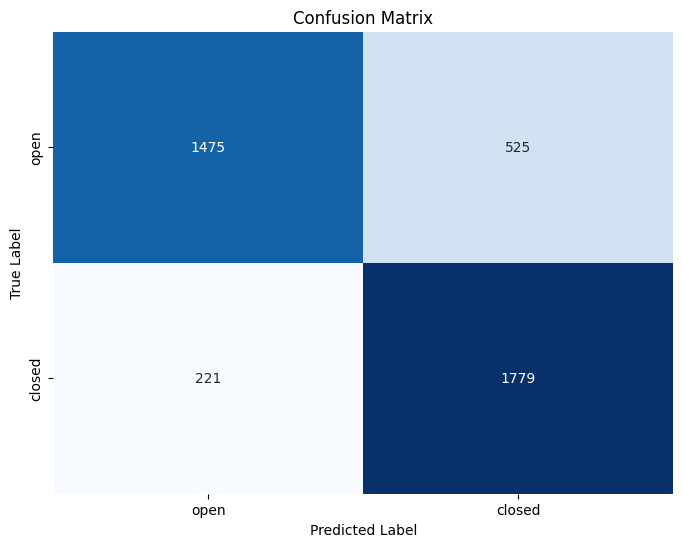

In [23]:
_, accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", accuracy)

# Predict classes for test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

# Compute confusion matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


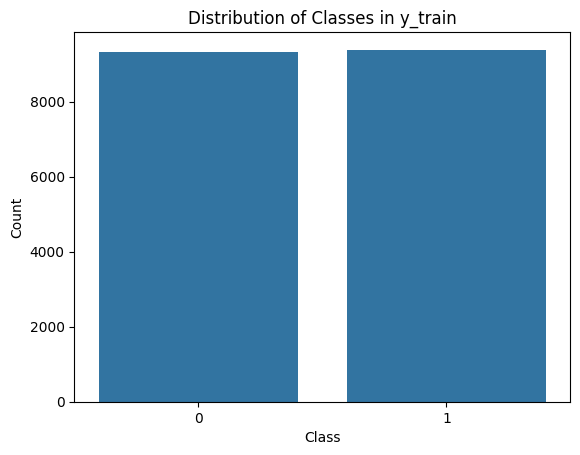

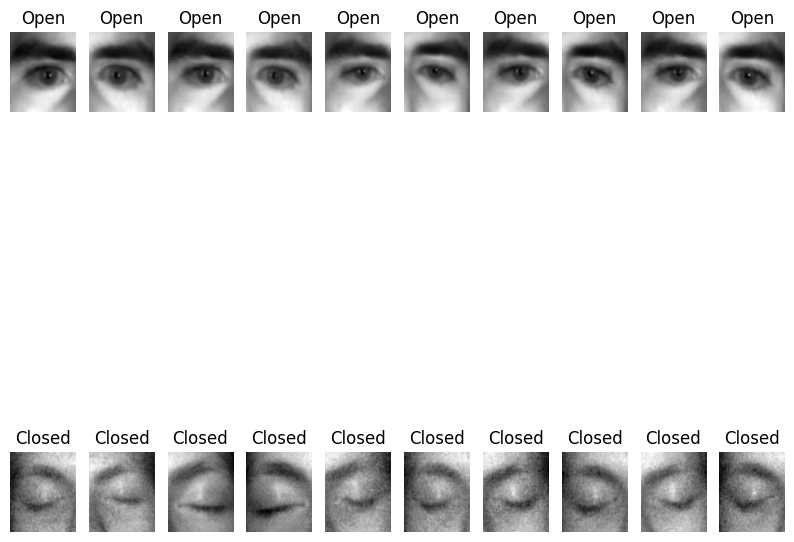

In [24]:
sns.countplot(x=np.argmax(y_train, axis=1))
plt.title('Distribution of Classes in y_train')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# Display sample images from X_train for both "open" and "closed" classes
num_samples_per_class = 10  # Number of samples to display for each class

# Display sample images for the "open" class
open_indices = np.where(np.argmax(y_train, axis=1) == 0)[0]
plt.figure(figsize=(10, 10))
for i in range(num_samples_per_class):
    plt.subplot(2, num_samples_per_class, i + 1)
    plt.imshow(X_train[open_indices[i]], cmap='gray')
    plt.title('Open')
    plt.axis('off')

# Display sample images for the "closed" class
closed_indices = np.where(np.argmax(y_train, axis=1) == 1)[0]
for i in range(num_samples_per_class):
    plt.subplot(2, num_samples_per_class, num_samples_per_class + i + 1)
    plt.imshow(X_train[closed_indices[i]], cmap='gray')
    plt.title('Closed')
    plt.axis('off')

plt.show()

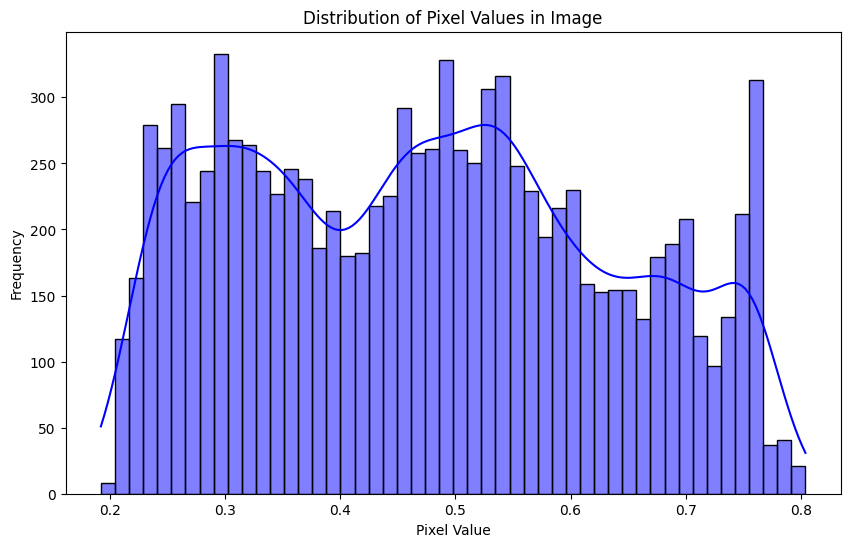

In [25]:


# Reshape images to a 1D array for visualization
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Plot the distribution of pixel values
plt.figure(figsize=(10, 6))
sns.histplot(X_train_flat[0], kde=True, color='blue', bins=50)  # Plot distribution for the first image
plt.title('Distribution of Pixel Values in Image')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.show()


In [26]:
model.save('models/new200finaldiya1.h5')

c:\Users\diyam\Documents\hello\venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
import os
import numpy as np
import cv2

# Define sigmoid activation function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define ReLU activation function
def relu(x):
    return np.maximum(0, x)

# Define derivative of sigmoid
def sigmoid_derivative(x):
    return sigmoid(x) * (1 - sigmoid(x))

# Define derivative of ReLU
def relu_derivative(x):
    return np.where(x > 0, 1, 0)

test_folder = 'F:\\Drowsiness detection\\dataset\\test'
train_folder = 'F:\\Drowsiness detection\\dataset\\train'

classes = ['open', 'closed']

X_train = []
y_train = []
X_test = []
y_test = []

img_size = (92, 112)

for i, class_name in enumerate(classes):
    class_path = os.path.join(train_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        X_train.append(img)
        y_train.append(i)

    class_path = os.path.join(test_folder, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, img_size, interpolation=cv2.INTER_AREA)
        X_test.append(img)
        y_test.append(i)

X_train = np.array(X_train, dtype=np.uint8)
y_train = np.array(y_train)
X_test = np.array(X_test, dtype=np.uint8)
y_test = np.array(y_test)

X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Convert labels to one-hot encoding
y_train = np.eye(2)[y_train]
y_test = np.eye(2)[y_test]

learning_rate = 0.001  # Define the learning rate

# Define custom Conv2D Layer
# Define custom Conv2D Layer
# Define custom Conv2D Layer
# Define custom Conv2D Layer
# Define custom Conv2D Layer
class Conv2D:
    def __init__(self, filters, kernel_size, activation='relu'):
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = activation
        self.weights = None  # Initialize weights to be set in the forward method
        self.bias = np.zeros(filters)

    def forward(self, inputs):
        self.inputs = inputs
        # Initialize weights here based on the input shape
        if self.weights is None:
            input_channels = inputs.shape[-1]
            self.weights = np.random.randn(self.kernel_size[0], self.kernel_size[1], input_channels, self.filters)
        conv_output = np.zeros((inputs.shape[0] - self.kernel_size[0] + 1,
                                inputs.shape[1] - self.kernel_size[1] + 1,
                                self.filters))
        for k in range(self.filters):
            for i in range(inputs.shape[0] - self.kernel_size[0] + 1):
                for j in range(inputs.shape[1] - self.kernel_size[1] + 1):
                    # Adjust the broadcasting of both inputs and weights
                    conv_output[i, j, k] = np.sum(inputs[i:i+self.kernel_size[0], j:j+self.kernel_size[1]] *
                                                   self.weights[:, :, :, k]) + self.bias[k]
        if self.activation == 'relu':
            return relu(conv_output)
        elif self.activation == 'sigmoid':
            return sigmoid(conv_output)



    def backward(self, d_out):
        d_input = np.zeros_like(self.inputs)
        d_weights = np.zeros_like(self.weights)
        d_bias = np.zeros_like(self.bias)
        if self.activation == 'relu':
            activation_derivative = relu_derivative
        elif self.activation == 'sigmoid':
            activation_derivative = sigmoid_derivative
        for k in range(self.filters):
            for i in range(d_out.shape[0]):
                for j in range(d_out.shape[1]):
                    d_input[i:i+self.kernel_size[0], j:j+self.kernel_size[1]] += d_out[i, j, k] * self.weights[:, :, k]
                    d_weights[:, :, k] += d_out[i, j, k] * self.inputs[i:i+self.kernel_size[0], j:j+self.kernel_size[1]]
                    d_bias[k] += d_out[i, j, k]
        return d_input, d_weights, d_bias

# Define custom MaxPooling2D Layer
class MaxPooling2DLayer:
    def __init__(self, pool_size):
        self.pool_size = pool_size

    def forward(self, inputs):
        self.inputs = inputs
        pooled_output = np.zeros((inputs.shape[0] // self.pool_size[0],
                                  inputs.shape[1] // self.pool_size[1],
                                  inputs.shape[2]))
        for i in range(0, inputs.shape[0], self.pool_size[0]):
            for j in range(0, inputs.shape[1], self.pool_size[1]):
                for k in range(inputs.shape[2]):
                    pooled_output[i//self.pool_size[0], j//self.pool_size[1], k] = np.max(inputs[i:i+self.pool_size[0], j:j+self.pool_size[1], k])
        return pooled_output

    def backward(self, d_out):
        d_input = np.zeros_like(self.inputs)
        for i in range(d_out.shape[0]):
            for j in range(d_out.shape[1]):
                for k in range(self.inputs.shape[2]):
                    window = self.inputs[i*self.pool_size[0]:i*self.pool_size[0]+self.pool_size[0],
                                          j*self.pool_size[1]:j*self.pool_size[1]+self.pool_size[1], k]
                    max_value = np.max(window)
                    d_input[i*self.pool_size[0]:i*self.pool_size[0]+self.pool_size[0],
                            j*self.pool_size[1]:j*self.pool_size[1]+self.pool_size[1], k] = (window == max_value) * d_out[i, j, k]
        return d_input

# Define custom Dropout Layer
class DropoutLayer:
    def __init__(self, rate):
        self.rate = rate

    def forward(self, inputs, training=True):
        if training:
            self.mask = np.random.rand(*inputs.shape) < self.rate
            return np.where(self.mask, 0, inputs)
        else:
            return inputs

    def backward(self, d_out):
        return np.where(self.mask, 0, d_out)

# Define custom Flatten Layer
class Flatten:
    def forward(self, inputs):
        self.input_shape = inputs.shape
        return inputs.flatten().reshape((inputs.shape[0], -1))

    def backward(self, d_out):
        return d_out.reshape(self.input_shape)

# Define custom Dense Layer
class Dense:
    def __init__(self, units, activation='relu'):
        self.units = units
        self.activation = activation
        self.weights = np.random.randn(units)
        self.bias = np.zeros(units)

    def forward(self, inputs):
        self.inputs = inputs
        dense_output = np.dot(inputs, self.weights) + self.bias
        if self.activation == 'relu':
            return relu(dense_output)
        elif self.activation == 'sigmoid':
            return sigmoid(dense_output)

    def backward(self, d_out):
        d_input = np.dot(d_out, self.weights.T)
        d_weights = np.dot(self.inputs.T, d_out)
        d_bias = np.sum(d_out, axis=0)
        return d_input, d_weights, d_bias

# Define custom Softmax Layer
class Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        probabilities = exp_values / np.sum(exp_values, axis=1, keepdims=True)
        return probabilities

    def backward(self, y_true, y_pred):
        batch_size = len(y_true)
        d_loss = y_pred - y_true
        return d_loss / batch_size

# Define custom Sequential model
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def add(self, layer):
        self.layers.append(layer)

    def forward(self, inputs, training=True):
        for layer in self.layers:
            inputs = layer.forward(inputs)
        return inputs

    def backward(self, d_out):
        for layer in reversed(self.layers):
            d_out = layer.backward(d_out)
        return d_out

    def predict(self, inputs):
        return self.forward(inputs, training=False)

    def train_step(self, X, y):
        # Forward pass
        logits = self.forward(X)
        loss = self.loss_fn(y, logits)
        
        # Backward pass
        grad = self.loss_fn.backward(y, logits)
        self.backward(grad)
        
        return loss

    def fit(self, X_train, y_train, epochs, batch_size, validation_data=None):
        for epoch in range(epochs):
            epoch_loss = 0
            for i in range(0, len(X_train), batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]
                loss = self.train_step(X_batch, y_batch)
                epoch_loss += loss
            epoch_loss /= (len(X_train) / batch_size)
            print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss}')
            if validation_data:
                val_loss = self.evaluate(validation_data[0], validation_data[1])
                print(f'Validation Loss: {val_loss}')

    def evaluate(self, X_test, y_test):
        y_pred = self.predict(X_test)
        loss = self.loss_fn(y_test, y_pred)
        return loss

    def compile(self, loss):
        self.loss_fn = loss

# Define custom Categorical Crossentropy Loss
class CategoricalCrossentropyLoss:
    def __call__(self, y_true, y_pred):
        # Avoid division by zero
        epsilon = 1e-15
        # Clip values to prevent NaNs in log
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Compute cross-entropy loss
        loss = -np.sum(y_true * np.log(y_pred)) / len(y_true)
        return loss

    def backward(self, y_true, y_pred):
        # Avoid division by zero
        epsilon = 1e-15
        # Clip values to prevent NaNs in log
        y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
        # Compute gradient of loss with respect to y_pred
        grad = -y_true / y_pred
        return grad

# Define custom Accuracy metric
class Accuracy:
    def __call__(self, y_true, y_pred):
        return np.mean(np.argmax(y_true, axis=1) == np.argmax(y_pred, axis=1))

# Create the model
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), activation='relu'),
    MaxPooling2DLayer(pool_size=(2, 2)),
    DropoutLayer(rate=0.25),
    Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2DLayer(pool_size=(2, 2)),
    DropoutLayer(rate=0.25),
    Flatten(),
    Dense(units=128, activation='relu'),
    DropoutLayer(rate=0.5),
    Dense(units=2, activation='softmax')
])

# Compile the model
model.compile(loss=CategoricalCrossentropyLoss())

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'F:\\Drowsiness detection\\dataset\\train\\open'